<a href="https://colab.research.google.com/github/Oleksii-Adamov/quantum-malicious-login-detection/blob/main/beth_aqora_challange_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [1]:
!pip install qiskit==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.1 MB/s eta 0:00:00


In [2]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 19.6 MB/s eta 0:00:00


In [3]:
!pip install qiskit-algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 12.9 MB/s eta 0:00:00


In [4]:
!pip install qiskit-machine-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 11.9 MB/s eta 0:00:00


In [5]:
!pip install joblib

# Mount Google Drive

In [2]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/BETH'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


# Imports

In [3]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load dataset

In [4]:
train_df = pd.read_csv(data_dir + '/training.csv')
val_df = pd.read_csv(data_dir + '/validation.csv')

In [5]:
test_df = pd.read_csv(data_dir + '/labelled_testing_data.csv')

# EDA

In [20]:
train_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [21]:
train_df.isna().any()

,0
timestamp,False
processId,False
threadId,False
parentProcessId,False
userId,False
mountNamespace,False
processName,False
hostName,False
eventId,False
eventName,False


In [22]:
train_df.evil.value_counts()

,count
evil,
0,763144


In [23]:
train_df.sus.value_counts()

,count
sus,
0,761875
1,1269


In [24]:
val_df.evil.value_counts()

,count
evil,
0,188967


In [25]:
val_df.sus.value_counts()

,count
sus,
0,188181
1,786


In [26]:
train_df.describe(include=['object', 'float', 'int'])

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
count,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,7.631440e+05,763144,763144,763144.000000,763144,763144,763144.000000,763144.000000,763144,763144.000000,763144.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,36,8,NaN,32,97050,NaN,NaN,214720,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,ps,ubuntu,NaN,close,[],NaN,NaN,"[{'name': 'fd', 'type': 'int', 'value': 9}]",NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,406313,190500,NaN,218080,521115,NaN,NaN,107321,NaN,NaN
mean,1844.582673,6814.763308,6820.265241,1882.216609,2.279034,4.026532e+09,NaN,NaN,288.158953,NaN,NaN,2.672082,17.520924,NaN,0.001663,0.0
std,1136.638249,1948.871187,1937.068333,2215.563094,37.416576,1.649030e+02,NaN,NaN,385.117778,NaN,NaN,1.340906,318.596662,NaN,0.040744,0.0
min,132.560721,1.000000,1.000000,0.000000,0.000000,4.026532e+09,NaN,NaN,3.000000,NaN,NaN,0.000000,-115.000000,NaN,0.000000,0.0
25%,903.250802,7313.000000,7313.000000,187.000000,0.000000,4.026532e+09,NaN,NaN,3.000000,NaN,NaN,1.000000,0.000000,NaN,0.000000,0.0
50%,1829.203642,7365.000000,7365.000000,1385.000000,0.000000,4.026532e+09,NaN,NaN,62.000000,NaN,NaN,3.000000,0.000000,NaN,0.000000,0.0
75%,2761.380825,7415.000000,7415.000000,1648.000000,0.000000,4.026532e+09,NaN,NaN,257.000000,NaN,NaN,4.000000,4.000000,NaN,0.000000,0.0


In [27]:
len(train_df['eventId'].unique())

32

In [28]:
train_df['args'][0]

"[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NAME'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140662171848350}, {'name': 'arg5', 'type': 'unsigned long', 'value': 140662156379904}]"

In [29]:
test_df['args'][0]

"[{'name': 'domain', 'type': 'int', 'value': 'AF_UNIX'}, {'name': 'type', 'type': 'int', 'value': 'SOCK_DGRAM|SOCK_CLOEXEC'}, {'name': 'protocol', 'type': 'int', 'value': 0}]"

In [30]:
import json
def obtain_args_df(df):
    args_dataframes = []
    for i in range(0, df.shape[0]):
        j_s = train_df['args'][i].replace('\"', '').replace('\'', '\"')
        interim_df = pd.json_normalize(json.loads(j_s))
        final_df = interim_df.unstack().to_frame().T.sort_index()
        final_df.columns = final_df.columns.map('{0[0]}_{0[1]}'.format)
        args_dataframes.append(final_df)
    return pd.concat(args_dataframes).reset_index(drop=True)

In [31]:
def args_df_to_file(df, output_file):
    with open(output_file, 'w') as f:
        first_row = True
        for i in range(df.shape[0]):
            #print(i)
            #print(df['args'][i])
            # Process the JSON string in the 'args' column
            j_s = df['args'][i].replace('\"', '').replace('\'', '\"').replace('\\', '|')
            #print(j_s)
            interim_df = pd.json_normalize(json.loads(j_s))
            final_df = interim_df.unstack().to_frame().T.sort_index()
            final_df.columns = final_df.columns.map('{0[0]}_{0[1]}'.format)
            final_df = final_df.reindex(columns=['name_0', 'name_1', 'name_2', 'name_3', 'name_4', 'type_0', 'type_1',
       'type_2', 'type_3', 'type_4', 'value_0', 'value_1', 'value_2',
       'value_3', 'value_4'])
            # Write to file in CSV format
            final_df.to_csv(f, header=first_row, index=False, mode='a')
            first_row = False  # Only include header for the first row

In [32]:
train_args_df = pd.read_csv(data_dir + '/train_args_df.csv')
train_args_df

,name_0,name_1,name_2,name_3,name_4,type_0,type_1,type_2,type_3,type_4,value_0,value_1,value_2,value_3,value_4
0,option,arg2,arg3,arg4,arg5,int,unsigned long,unsigned long,unsigned long,unsigned long,PR_SET_NAME,94819493392601,94819493392601,140662171848350,140662156379904.0
1,fd,none,none,none,none,int,none,none,none,none,19,none,none,none,none
2,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none
3,pathname,mode,none,none,none,const char*,int*,none,none,none,/etc/ld.so.preload,R_OK,none,none,none
4,pathname,flags,dev,inode,none,const char*,int,dev_t,unsigned long,none,/etc/ld.so.cache,O_RDONLY|O_LARGEFILE,211812353,62841,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763139,cap,none,none,none,none,int,none,none,none,none,CAP_KILL,none,none,none,none
763140,pid,sig,none,none,none,pid_t,int,none,none,none,0,15,none,none,none
763141,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none
763142,none,none,none,none,none,none,none,none,none,none,none,none,none,none,none


In [33]:
train_args_df.columns

Index(['name_0', 'name_1', 'name_2', 'name_3', 'name_4', 'type_0', 'type_1',
       'type_2', 'type_3', 'type_4', 'value_0', 'value_1', 'value_2',
       'value_3', 'value_4'],
      dtype='object')

In [34]:
train_args_df['name_0'].value_counts()

,count
name_0,
fd,304366
pathname,215119
dirfd,210152
cap,9825
sockfd,7691
domain,5971
pid,2818
oldfd,2763
none,1409


In [35]:
train_args_df['name_1'].value_counts()

,count
name_1,
none,232018
pathname,210152
flags,148615
statbuf,129033
mode,14449
addr,7691
dirp,6149
type,5971
sig,2818


In [36]:
train_args_df['name_2'].value_counts()

,count
name_2,
none,381291
flags,210172
dev,148611
addrlen,7691
count,6149
protocol,5971
arg3,1379
parent_tid,1299
inode,581


In [37]:
train_args_df['name_3'].value_counts()

,count
name_3,
none,401353
mode,209730
inode,148611
arg4,1379
child_tid,1299
flags,772


In [38]:
train_args_df['name_4'].value_counts()

,count
name_4,
none,760466
arg5,1379
tls,1299


In [39]:
train_args_df['value_0'].value_counts()

,count
value_0,
-100,163778
9,109665
6,77431
15,65332
3,36763
...,...
/proc/7647/oom_score_adj,1
7645,1
/proc/7644/fd,1


# Preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
fr_encode_maps = []
def preprocess_data(df, is_train=True):
    global fr_encode_maps
    df = df.copy()
    # process columns as suggested by the paper http://www.gatsby.ucl.ac.uk/~balaji/udl2021/accepted-papers/UDL2021-paper-033.pdf
    df['isOSprocessId'] = (df['processId'] < 3).astype('int')
    df['isParentOSprocessId'] = (df['parentProcessId'] < 3).astype('int')
    df['isDefaultMount'] = (df['mountNamespace'] == 4026531840).astype('int')
    df['isOSUser'] = (df['userId'] < 1000).astype('int')
    df.loc[df['returnValue'] < 0, "returnValue"] = -1
    df.loc[df['returnValue'] > 0, "returnValue"] = 1
    # might add back: threadId processName stackAddresses args
    df = df.drop(columns=['timestamp', 'processId', 'parentProcessId', 'userId', 'mountNamespace', 'processName', 'hostName', 'eventName', 'stackAddresses', 'args'])

    fr_encode_columns = ['eventId', 'threadId']

    if is_train:
        # delete 'sus' entries
        df = df[df['sus'] == 0]
        labels = None
        fr_encode_maps = [df[column].value_counts(normalize=True) for column in fr_encode_columns]

    else:
        df.loc[df['evil'] == 1, "evil"] = -1
        df.loc[df['evil'] == 0, "evil"] = 1
        labels = df['evil']
        for column, fr_map in zip(fr_encode_columns, fr_encode_maps):
            unq = df[column].unique()
            for item in unq:
                if not item in fr_map.keys():
                    fr_map[item] = 0
    # drop labels
    df = df.drop(columns=['sus', 'evil'])

    # frequency encode
    for column, fr_map in zip(fr_encode_columns, fr_encode_maps):
        df[column] = df[column].map(fr_map)

    df = df.astype(float)
    # scale
    if is_train:
        scaler.fit(pd.DataFrame(df['argsNum']))
    df['argsNum'] = scaler.transform(pd.DataFrame(df['argsNum']))

    return df, labels

In [7]:
pr_train_df, _ = preprocess_data(train_df)

In [8]:
pr_test_df, test_labels = preprocess_data(test_df, is_train = False)

In [9]:
pr_train_df

,threadId,eventId,argsNum,returnValue,isOSprocessId,isParentOSprocessId,isDefaultMount,isOSUser
273,0.000158,0.018860,-0.2,-1.0,0.0,1.0,0.0,1.0
274,0.021418,0.012896,-0.6,0.0,1.0,1.0,1.0,1.0
275,0.021418,0.003699,-0.2,0.0,1.0,1.0,1.0,1.0
276,0.021418,0.012896,-0.6,0.0,1.0,1.0,1.0,1.0
277,0.021418,0.003699,-0.2,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
763139,0.000966,0.012896,-0.6,0.0,0.0,0.0,1.0,1.0
763140,0.000966,0.003699,-0.2,0.0,0.0,0.0,1.0,1.0
763141,0.000966,0.001805,-1.0,0.0,0.0,0.0,1.0,1.0
763142,0.000726,0.001805,-1.0,0.0,0.0,1.0,1.0,1.0


# Preprocessed EDA

In [44]:
pr_train_df.head()

,threadId,eventId,argsNum,returnValue,isOSprocessId,isParentOSprocessId,isDefaultMount,isOSUser
273,0.000158,0.018860,-0.2,-1.0,0.0,1.0,0.0,1.0
274,0.021418,0.012896,-0.6,0.0,1.0,1.0,1.0,1.0
275,0.021418,0.003699,-0.2,0.0,1.0,1.0,1.0,1.0
276,0.021418,0.012896,-0.6,0.0,1.0,1.0,1.0,1.0
277,0.021418,0.003699,-0.2,0.0,1.0,1.0,1.0,1.0


In [45]:
pr_train_df['isOSprocessId'].value_counts()

,count
isOSprocessId,
0.0,745557
1.0,16318


In [46]:
pr_train_df['isDefaultMount'].value_counts()

,count
isDefaultMount,
1.0,566263
0.0,195612


In [47]:
pr_train_df['returnValue'].value_counts()

,count
returnValue,
0.0,526101
1.0,213286
-1.0,22488


In [48]:
pr_train_df['isOSUser'].value_counts()

,count
isOSUser,
1.0,761875


# Take train subset

In [10]:
n_samples = 8000

In [11]:
from sklearn.utils import shuffle

X_train = shuffle(pr_train_df, random_state=0, n_samples=n_samples)

# Take test subset

In [12]:
pr_test_df, test_labels = preprocess_data(test_df, is_train = False)

In [13]:
from sklearn.utils import shuffle
X_test, y_test = shuffle(pr_test_df, test_labels, random_state=0, n_samples= 1000)

# Classical OneClassSVM Train

In [53]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(gamma=0.2, nu=0.05).fit(X_train)

In [54]:
y_pred = clf.predict(X_test)

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=-1))
print('Recall:', recall_score(y_test, y_pred, pos_label=-1))
print('F1 score:', f1_score(y_test, y_pred, pos_label=-1))

Accuracy: 0.961
Precision: 0.9613130128956624
Recall: 0.9927360774818402
F1 score: 0.9767718880285885


# Classical SGDOneClassSVM train

In [14]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline

# Define a custom kernel approximation using Nystroem
n_components = 100
nystroem = Nystroem(kernel='rbf', gamma=0.2, n_components=n_components, random_state=0)

# Define the SGDOneClassSVM
sgd_ocsvm = SGDOneClassSVM(max_iter=100, tol=1e-3, nu=0.05, random_state=0)

# Create a pipeline that first applies the kernel approximation and then trains the SGDOneClassSVM
pipeline = make_pipeline(nystroem, sgd_ocsvm)

# Fit the model
pipeline.fit(X_train) # pr_train_df

Pipeline(steps=[('nystroem', Nystroem(gamma=0.2, random_state=0)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=100, nu=0.05, random_state=0))])

In [15]:
y_pred = pipeline.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=-1))
print('Recall:', recall_score(y_test, y_pred, pos_label=-1))
print('F1 score:', f1_score(y_test, y_pred, pos_label=-1))

Accuracy: 0.962
Precision: 0.9624413145539906
Recall: 0.9927360774818402
F1 score: 0.9773539928486293


In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

param_grid = {
    "kernel": ['rbf', 'poly', 'sigmoid'],
    "gamma": np.linspace(0.01, 1, num=100),
    "average": [True, False],
    "learning_rate": ['invscaling', 'constant', 'optimal', 'adaptive'],
    "nu": np.linspace(0.0001, 0.3, num=100),
    "tol": [1e-9],
    "eta0": [0.001]
}

grid = ParameterGrid(param_grid)
best_score = 0
best_model = None
for params in grid:
    n_components = 100
    nystroem = Nystroem(kernel=params["kernel"], gamma=params["gamma"], n_components=n_components, random_state=0)
    sgd_ocsvm = SGDOneClassSVM(max_iter=100, tol=params["tol"], nu=params["nu"], random_state=0, learning_rate=params["learning_rate"], eta0 = params["eta0"], average = params["average"])
    X_train_transformed = nystroem.fit_transform(X_train)
    sgd_ocsvm.fit(X_train_transformed)
    X_test_transformed = nystroem.transform(X_test)
    y_pred = sgd_ocsvm.predict(X_test_transformed)
    score = f1_score(y_test, y_pred, pos_label=-1)
    if score > best_score:
        best_score = score
        best_model = sgd_ocsvm
        print("New best score:", score)
        #joblib.dump(best_model, data_dir + '/sgd_ocsvm_model_8000_v100_f_' + str(score) + '.pkl')

New best score: 0.009557945041816009
New best score: 0.950345694531741
New best score: 0.958904109589041
New best score: 0.9641089108910891
New best score: 0.9751062537947783
New best score: 0.9751364463311097
New best score: 0.9761904761904762
New best score: 0.9767995240928019
New best score: 0.9773809523809524
New best score: 0.9831932773109243
New best score: 0.9832134292565947


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:2542: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:2542: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:2542: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:2542: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stocha

New best score: 0.9867469879518073


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:2542: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:2542: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:2542: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:2542: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stocha

New best score: 0.9891304347826086


# Quantum SGDOneClassSVM train

In [59]:
import qiskit

In [60]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = ZZFeatureMap(feature_dimension=pr_train_df.shape[1], reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map, evaluate_duplicates='none')

<ipython-input-60-1136343585>:8: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [61]:
import matplotlib.pyplot as plt

In [62]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=e5350c8ebee7961733cd97b7bb0a7d2388c52a9e714705546cb472cf6a181db4
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [63]:
import pylatexenc

In [64]:
from qiskit.circuit.library import ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement="linear")

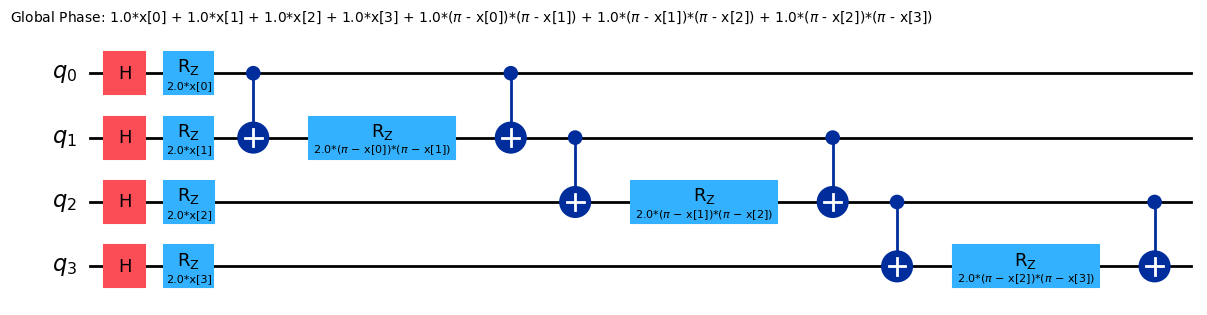

In [66]:
from qiskit import transpile
feature_map_tr = transpile(feature_map, basis_gates=['h', 'rz', 'cx'])
feature_map_tr.draw('mpl')

In [76]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline

# Define a custom kernel approximation using Nystroem
n_components = 100
nystroem = Nystroem(kernel=quantum_kernel.evaluate, n_components=n_components, random_state=0)
nystroem.fit(X_train.iloc)

Nystroem(kernel=<bound method FidelityQuantumKernel.evaluate of <qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x7c9d66c58cd0>>,
         random_state=0)

In [ ]:
joblib.dump(nystroem, data_dir + '/nystroem_kernel.pkl')

['drive/My Drive/BETH/nystroem_kernel_3000_v100.pkl']

In [ ]:
start = time.time()
X_train_transformed = nystroem.transform(X_train)
end = time.time()
print('Nystroem execution time [sec]:', end - start)

Nystroem execution time [sec]: 3822.9181003570557


In [ ]:
joblib.dump(X_train_transformed, data_dir + '/X_train_transformed.pkl')

['drive/My Drive/BETH/X_train_transformed_3000_v100.pkl']

In [ ]:
X_test_transformed = nystroem.transform(X_test)

In [ ]:
joblib.dump(X_test_transformed, data_dir + '/X_test_transformed.pkl')

['drive/My Drive/BETH/X_test_transformed_3000_v100.pkl']

In [ ]:
sgd_ocsvm = SGDOneClassSVM(max_iter=1000, tol=1e-3, nu=0.05, random_state=0, learning_rate='invscaling', eta0 = 0.01, average = True)
sgd_ocsvm.fit(X_train_transformed)

SGDOneClassSVM(average=True, eta0=0.01, learning_rate='invscaling', nu=0.05,
               random_state=0)

In [ ]:
sgd_ocsvm.n_iter_

6

In [ ]:
joblib.dump(sgd_ocsvm, data_dir + '/sgd_ocsvm_model.pkl')

['drive/My Drive/BETH/sgd_ocsvm_model_12000_v0.pkl']

In [ ]:
y_pred = sgd_ocsvm.predict(X_test_transformed)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=-1))
print('Recall:', recall_score(y_test, y_pred, pos_label=-1))
print('F1 score:', f1_score(y_test, y_pred, pos_label=-1))

Accuracy: 0.979
Precision: 0.9831932773109243
Recall: 0.9915254237288136
F1 score: 0.9873417721518988


# Finetune

In [ ]:
X_train_transformed = joblib.load(data_dir + '/X_train_transformed_8000_v100.pkl')
X_test_transformed = joblib.load(data_dir + '/X_test_transformed_8000_v100.pkl')

In [ ]:
param_grid = {
    "average": [True, False],
    "learning_rate": ['invscaling', 'constant', 'optimal', 'adaptive'],
    "nu": np.linspace(0.0001, 0.3, num=100),
    "tol": [1e-9],
    "eta0": [0.001],
}

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import SGDOneClassSVM

grid = ParameterGrid(param_grid)
best_score = 0
best_model = None
for params in grid:
    sgd_ocsvm = SGDOneClassSVM(max_iter=1000, tol=params["tol"], nu=params["nu"], random_state=0, learning_rate=params["learning_rate"], eta0 = params["eta0"], average = params["average"])
    sgd_ocsvm.fit(X_train_transformed)
    y_pred = sgd_ocsvm.predict(X_test_transformed)
    score = f1_score(y_test, y_pred, pos_label=-1)
    #score = accuracy_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_model = sgd_ocsvm
        print("New best score:", score)
        joblib.dump(best_model, data_dir + '/sgd_ocsvm_model_3000_' + str(score) + '.pkl')

New best score: 0.9544303797468354
New best score: 0.9630094043887147
New best score: 0.9828431372549019
New best score: 0.9878493317132442
New best score: 0.9879518072289156
New best score: 0.9885473176612417
New best score: 0.9890510948905109
New best score: 0.9891435464414958
New best score: 0.9897156684815487
New best score: 0.9897404948702474
New best score: 0.9909255898366606


In [ ]:
best_model.n_iter_

6

In [ ]:
best_model.nu, best_model.learning_rate, best_model.eta0, best_model.average

(0.024334343434343434, 'constant', 0.001, False)

In [ ]:
joblib.dump(best_model, data_dir + '/best_model.pkl')

['drive/My Drive/BETH/sgd_ocsvm_model_12000_v1.pkl']